# Import libraries:

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newcarsalesnorway/norway_new_car_sales_by_month.csv
/kaggle/input/newcarsalesnorway/norway_new_car_sales_by_model.csv
/kaggle/input/newcarsalesnorway/norway_new_car_sales_by_make.csv


In [9]:
import scipy.stats
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [ ]:
import plotly.express as px

In [ ]:
!pip install nb_black -q

In [ ]:
!pip install prophet

In [ ]:
%load_ext nb_black

# Data analysis:

In [10]:
df_month = pd.read_csv('/kaggle/input/newcarsalesnorway/norway_new_car_sales_by_month.csv')

df_make = pd.read_csv('/kaggle/input/newcarsalesnorway/norway_new_car_sales_by_make.csv')

## Monthly sales

In [ ]:
df_month.head(5)

In [ ]:
df_month.describe().T

In [ ]:
df_month.info()

In [ ]:
df_month.Used.describe().T

One of the challenges we are facing is that some of the data is missing, specifically in the "Used" column. This column represents the number of units that have been used within the country, and it's an important feature for our analysis. To address this issue, we have decided to use a statistical technique called imputation. We will use mathematical models to estimate the missing values in the "Used" column based on the available data. This will allow us to fill in all the missing values and complete our dataset. This will help us to make our analysis more accurate and reliable.

In [ ]:
df_month

In [11]:
from sklearn.impute import KNNImputer

# Create an instance of the KNNImputer class
imputer = KNNImputer(n_neighbors=5)

# Fit the imputer to the data
imputer.fit(df_month)

# Use the imputer to transform the data and replace the missing values with the imputed values
df_imputed = imputer.transform(df_month)
df_imputed = pd.DataFrame(imputer.transform(df_month), columns = df_month.columns)
df_month = df_imputed

In [ ]:
df_month 

In [ ]:
df_month.columns

## Feature engenieer

In [12]:
df_month['Cicle'] = (-np.cos(0.5236 * df_month['Month']))

In [13]:
# create new column Import_Ratio
df_month['Import_Ratio'] = df_month['Import'] / df_month['Quantity']

# create new column Import_Ratio_YoY
df_month['Import_Ratio_YoY'] = df_month['Import_Ratio'].pct_change()

# create new column Used_Ratio
df_month['Used_Ratio'] = df_month['Used'] / df_month['Quantity']

# create new column Used_Ratio_YoY
df_month['Used_Ratio_YoY'] = df_month['Used_Ratio'].pct_change()

# create new column CO2_Emission_Ratio
df_month['CO2_Emission_Ratio'] = df_month['Avg_CO2'] / df_month['Quantity']

# create new column Diesel_Ratio
df_month['Diesel_Ratio'] = df_month['Quantity_Diesel'] / df_month['Quantity']

# create new column Hybrid_Ratio
df_month['Hybrid_Ratio'] = df_month['Quantity_Hybrid'] / df_month['Quantity']

# create new column Electric_Ratio
df_month['Electric_Ratio'] = df_month['Quantity_Electric'] / df_month['Quantity']

# create new column Electric_Import_Ratio
df_month['Electric_Import_Ratio'] = df_month['Import_Electric'] / df_month['Import']

df_month.head(3)


,Year,Month,Quantity,Quantity_YoY,Import,Import_YoY,Used,Used_YoY,Avg_CO2,Bensin_Co2,Diesel_Co2,Quantity_Diesel,Diesel_Share,Diesel_Share_LY,Quantity_Hybrid,Quantity_Electric,Import_Electric,Cicle,Import_Ratio,Import_Ratio_YoY,Used_Ratio,Used_Ratio_YoY,CO2_Emission_Ratio,Diesel_Ratio,Hybrid_Ratio,Electric_Ratio,Electric_Import_Ratio
0,2007.0,1.0,12685.0,5227.0,2276.0,257.0,33125.0,3940.8,152.0,155.0,152.0,10072.0,79.4,52.5,404.8,250.8,204.6,-0.866025,0.179425,NaN,2.611352,NaN,0.011983,0.794009,0.031912,0.019771,0.089895
1,2007.0,2.0,9793.0,2448.0,1992.0,-89.0,34102.2,1668.6,156.0,159.0,155.0,7222.0,73.7,47.4,393.0,406.0,168.8,-0.499998,0.203411,0.133683,3.482304,0.333525,0.015930,0.737466,0.040131,0.041458,0.084739
2,2007.0,3.0,11264.0,1445.0,2626.0,45.0,36676.0,1632.4,159.0,161.0,158.0,7965.0,70.7,48.1,364.4,183.0,170.0,0.000004,0.233132,0.146116,3.256037,-0.064976,0.014116,0.707120,0.032351,0.016246,0.064737


## Correlation

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_month.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [ ]:
df_month.corr()

In [14]:
# calculate the correlation between columns
corr_matrix = df_month.corr()

# select the correlation of Quantity column
quantity_corr = corr_matrix['Quantity'].abs()

# sort the correlation values in descending order
quantity_corr.sort_values(ascending=False, inplace=True)

# print the sorted correlation values
print(quantity_corr)


Quantity                 1.000000
CO2_Emission_Ratio       0.937564
Used_Ratio               0.819996
Avg_CO2                  0.693300
Diesel_Co2               0.685538
Bensin_Co2               0.664581
Year                     0.653161
Diesel_Ratio             0.572641
Diesel_Share             0.571153
Quantity_YoY             0.521696
Import_Ratio             0.492037
Diesel_Share_LY          0.486683
Used                     0.476903
Used_YoY                 0.437380
Import_Electric          0.416476
Quantity_Electric        0.394345
Quantity_Hybrid          0.393684
Electric_Import_Ratio    0.332003
Used_Ratio_YoY           0.277115
Import_YoY               0.261060
Hybrid_Ratio             0.150052
Import_Ratio_YoY         0.138825
Electric_Ratio           0.120653
Cicle                    0.079016
Month                    0.057991
Import                   0.046455
Quantity_Diesel          0.028649
Name: Quantity, dtype: float64


The high correlation coefficients between the Quantity column and certain other columns in the dataset, such as CO2_Emission_Ratio, Used_Ratio, Avg_CO2, Diesel_Co2, Bensin_Co2 and Year indicate that there is a strong relationship between these columns and the number of units sold.

For example, a high correlation between Quantity and CO2_Emission_Ratio could indicate that as the average CO2 emissions per unit sold increase, the number of units sold decreases. This could be because of increasing environmental regulations and concerns, leading to a decrease in demand for higher emission vehicles.

A high correlation between Quantity and Used_Ratio could indicate that as the proportion of used cars in total sales increases, the number of units sold increases. This could be because used cars are generally cheaper than new cars, making them more accessible to a larger portion of the population.

A high correlation between Quantity and Avg_CO2 could indicate that as the average CO2 emissions of all cars sold in a given month decreases, the number of units sold increases. This could be because of increasing environmental regulations and concerns, leading to an increase in demand for lower emission vehicles.

A high correlation between Quantity and Year could indicate that as the years go by the number of units sold increases, this could be because of several reasons, such as population growth, increase in the number of people with access to credit, and increase in the number of people with driver licenses

In [ ]:
import plotly.express as px

# Create scatter matrix plot
fig = px.scatter_matrix(df_month, dimensions=["Quantity","CO2_Emission_Ratio", "Used_Ratio", "Avg_CO2", "Diesel_Co2"], color="Quantity", title="Scatter matrix of Quantity and other features")
# Show plot
fig.show()


### Graph this relationships

In [ ]:
fig = px.scatter(df_month, x='CO2_Emission_Ratio', y='Quantity')
fig.show()


In [ ]:
fig = px.line(df_month, x='Year', y='Quantity')
fig.show()


In [ ]:
fig = px.scatter(df_month, x='Diesel_Ratio', y='Quantity', color='Year')
fig.show()

In [ ]:
fig = px.scatter(df_month, x='Diesel_Ratio', y='Quantity', color='Year')
fig.show()



In [ ]:
df_month.groupby('Month')['Quantity'].sum().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.show()


## EDA

In [ ]:
df_month

In [124]:
df_month["Year"] = pd.to_numeric(df_month["Year"])
df_month["Year"] = df_month["Year"].astype(int)
df_month["Month"] = pd.to_numeric(df_month["Month"])
df_month["Month"] = df_month["Month"].astype(int)

In [125]:
df_month["Year"] = df_month["Year"].astype(str)
df_month["Month"] = df_month["Month"].astype(str)

df_month["Date"] = df_month["Year"].str.cat(
    df_month["Month"].str.zfill(2), sep="-"
)
df_month["Year"] = df_month["Year"].astype(int)
df_month["Month"] = df_month["Month"].astype(int)
df_month["Quantity"] = df_month["Quantity"].astype(int)

df_month.Date[:5]

0    2007-01
1    2007-02
2    2007-03
3    2007-04
4    2007-05
Name: Date, dtype: object

In [126]:
fig = px.bar(
    df_month,
    x="Date",
    y="Quantity",
    hover_data=["Year", "Month", "Quantity"],
    color="Quantity",
    text="Quantity",
    height=600,
    width=2400,
)
fig.update_traces(texttemplate="%{text:.2s}", textposition="outside")
fig.show()

NameError: name 'px' is not defined

<AxesSubplot:xlabel='Year', ylabel='Month'>

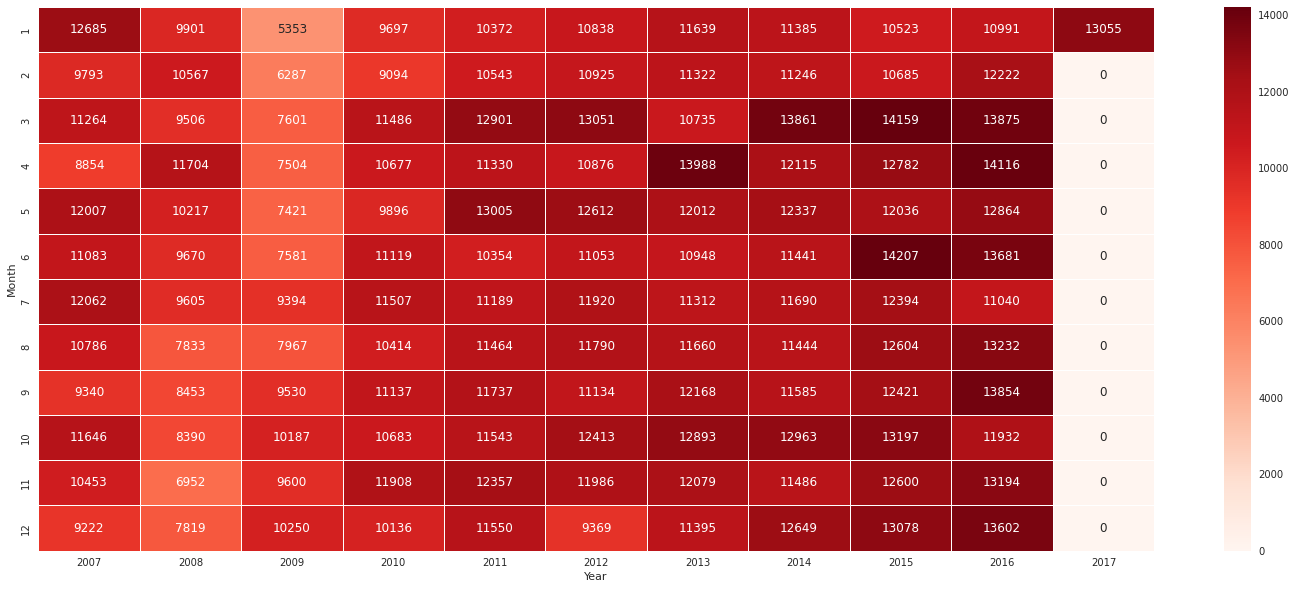

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

aux_csm = df_month[["Month", "Year", "Quantity"]]
plt.figure(figsize=(25, 10))
sns.heatmap(
    aux_csm.pivot("Month", "Year", "Quantity").fillna(0).astype(int),
    annot=True,
    fmt="d",
    linewidths=0.5,
    cmap="Reds",
)

In [ ]:
import plotly.graph_objects as go


def plot_var_comp(df, column, title, xlabel, ylabel):
    df["d" + column] = df[column].diff()
    df["d2" + column] = df["d" + column].diff()

    # Create traces
    x = df.Date
    y = df[column]  # y
    dy = df["d" + column]  # dy'
    d2y = df["d2" + column]  # dy''
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, mode="lines", name=column))
    fig.add_trace(go.Scatter(x=x, y=dy, mode="lines", name=f"Increase of {column}"))
    fig.add_trace(go.Scatter(x=x, y=d2y, mode="lines", name="Increase's Acceleration"))
    fig.update_layout(
        title=title, xaxis_title=xlabel, yaxis_title=ylabel,
    )
    fig.show()


plot_var_comp(
    df_month,
    "Quantity",
    "Sales and your components",
    "Date",
    "Number of sales",
)

In [ ]:


# Create scatter matrix plot
fig = px.scatter_matrix(df_month, dimensions=["Quantity", "Used", "Avg_CO2","Diesel_Co2","Bensin_Co2","Quantity_Diesel","Diesel_Share","Quantity_YoY","Import_Ratio"],
                        color="Quantity", title="Scatter matrix of Quantity and other features")

# Show plot
fig.show()


In [ ]:
fig = px.scatter_3d(df_month, x='Year', y='Month', z='Avg_CO2', color='Quantity', size='Quantity', title="3D Scatter Plot of Quantity, Year, Month and AVG_CO2")

fig.show()

This code creates a 3D scatter plot that displays the relationship between 'Quantity', 'Year', 'Month' and 'Avg_CO2' in a three-dimensional space. It's a complex graph that can give a lot of insights about the data, also it's an elegant and professional way to show your analysis to other people.

You can see how the 'Quantity' changes based on the 'Year', 'Month' and 'Avg_CO2'. The graph shows how the 'Quantity' of sales changes over time, month to month, and how the AVG_CO2 changes with the Quantity. You can see how the Quantity of sales decrease over the years and how the AVG_CO2 increase over the years.

The graph shows that the 'Quantity' of sales is higher when the 'Avg_CO2' is lower, this indicates that the cars with lower CO2 emissions are more attractive to the consumers. Also, you can see that the 'Quantity' of sales is higher during the months of the year where the 'Avg_CO2' is lower, indicating that the customers are more willing to buy cars during the months where the 'Avg_CO2' is lower.

This graph can help you understand the relationship between 'Quantity', 'Year', 'Month', and 'Avg_CO2' in a more visual and interactive way. It can help you identify patterns and trends in the data that may not be as apparent in a table or a simple plot, and it can be used to support my analysis and predictions about the sales.

# Forecast

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12, 5))
plt.title("Autocorrelation of Quantity")
ax = autocorrelation_plot(df_month["Quantity"])

In [ ]:
fig = px.box(
    df_month,
    y="Quantity",
    facet_col="Year",
    color="Year",
    boxmode="overlay",
    points="all",
)

fig.show()

In [ ]:
fig = go.Figure(data=go.Histogram(x=df_month['Quantity']))

fig.update_layout(title='Quantity Distribution', xaxis_title='Quantity', yaxis_title='Frequency')

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_month['Date'], y=df_month['Quantity'], name='Quantity'))
fig.add_trace(go.Scatter(x=df_month['Date'], y=df_month['Used'], name='Used'))


fig.update_layout(title='Trend Comparison', xaxis_title='Date', yaxis_title='Value')

fig.show()

In [128]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df_month.Quantity, period=12)
df = {
    "observed": res.observed,
    "trend": res.trend,
    "seasonal": res.seasonal,
    "resid": res.resid,
}
res = pd.DataFrame(df)
res.head()

,observed,trend,seasonal,resid
0,12685.0,NaN,-946.376852,NaN
1,9793.0,NaN,-709.413889,NaN
2,11264.0,NaN,845.475000,NaN
3,8854.0,NaN,591.808333,NaN
4,12007.0,NaN,278.683333,NaN


In [133]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Defining variables
fig = make_subplots(shared_xaxes=True,rows=4, cols=1)
x = df_month.Date
y = res.observed
z =res.trend
k =res.seasonal
w =res.resid

# Ploting the lines
fig.append_trace(go.Scatter(
    x=x,
    y=y,
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=x,
    y=z,
), row=2, col=1)

fig.append_trace(go.Scatter(
    x=x,
    y=k
), row=3, col=1)

fig.append_trace(go.Scatter(
    x=x,
    y=w
), row=4, col=1)

# Update properties and descriptions
fig.update_layout(height=700, width=1400, title_text="Statsmodel")
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Resid/Noise", row=4, col=1)
fig.show()

In [ ]:
df_month["sma_Quantity"] = df_month.Quantity.rolling(10).mean()
plot_var_comp(
    df_month,
    "sma_Quantity",
    "Sales and your components with SMA",
    "Date",
    "SMA to Number of sales",
)

## prophet


In [121]:
!pip install --upgrade plotly

In [129]:
from prophet import Prophet
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


def format_to_prophet(serie_ds, serie_y):
    aux = pd.DataFrame()
    aux["ds"] = serie_ds
    aux["y"] = serie_y
    return aux


X = df_month.Date
Y = df_month.Quantity
prophet_data = format_to_prophet(X, Y)


def train_and_plot(cps, prophet_data, plot=False):
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=cps)
    model.fit(prophet_data)

    future = model.make_future_dataframe(periods=12, freq="M")
    forecast = model.predict(future)

    r2 = round(r2_score(prophet_data["y"], forecast["yhat"][:-12]), 3)
    mse = round(mean_squared_error(prophet_data["y"], forecast["yhat"][:-12]), 3)
    mae = round(mean_absolute_error(prophet_data["y"], forecast["yhat"][:-12]), 3)

    if plot:
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=forecast["ds"],
                y=forecast["yhat"],
                mode="lines",
                name="Predict Values",
            )
        )
        fig.add_trace(
            go.Scatter(
                x=forecast["ds"], y=forecast["trend"], mode="lines", name="Trend"
            )
        )
        fig.add_trace(
            go.Scatter(
                x=prophet_data["ds"],
                y=prophet_data["y"],
                mode="lines",
                name="Real Values",
            )
        )
        fig.update_layout(
            title_text=f"Comperating the real x predicted for car sales",
            yaxis_title=f"Sales",
            xaxis_title="Date",
        )

        fig.show()
        print("R2: ", r2)
        print("MSE: ", mse)
        print("MAE: ", mae)
    else:
        return {"CPS": cps, "R2": r2, "MSE": mse, "MAE": mae}

In [ ]:
df_month.tail(3)

In [130]:
from joblib import Parallel, delayed

cps_options = [round(x, 1) for x in np.linspace(start=0.1, stop=10, num=100)]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_and_plot)(i, prophet_data) for i in cps_options
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
15:26:41 - cmdstanpy - INFO - Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing
15:26:41 - cmdstanpy - INFO - Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing
15:26:41 - cmdstanpy - INFO - Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing
15:26:42 - cmdstanpy - INFO - Chain [1] start processing
15:26:42 - cmdstanpy - INFO - Chain [1] start processing
15:26:42 - cmdstanpy - INFO - Chain [1] start processing
15:26:42 - cmdstanpy - INFO - Chain [1] done processing
15:26:42 - cmdstanpy - INFO - Chain [1] start processing
15:26:42 - cmdstanpy - INFO - Chain [1] done processing
15:26:42 - cmdstanpy - INFO - Chain [1] done processing
15:26:42 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=-1)

In [131]:
results = pd.DataFrame(results)
results = results[results.R2.isin([max(results.R2)])]
results = results[results.MSE.isin([min(results.MSE)])]
results

,CPS,R2,MSE,MAE
98,9.9,0.827,526467.976,567.301


In [134]:
train_and_plot(results.CPS.iloc[0], prophet_data, True)

15:27:42 - cmdstanpy - INFO - Chain [1] start processing
15:27:42 - cmdstanpy - INFO - Chain [1] done processing


R2:  0.827
MSE:  526467.976
MAE:  567.301


### Train and test

In [135]:
cps = results.CPS.iloc[0]

In [138]:
model = Prophet(yearly_seasonality=True, changepoint_prior_scale=cps)
model.fit(prophet_data[:-12])

future = model.make_future_dataframe(periods=12, freq="M")
forecast = model.predict(future)


15:28:14 - cmdstanpy - INFO - Chain [1] start processing
15:28:14 - cmdstanpy - INFO - Chain [1] done processing


In [143]:
prophet = forecast['yhat'][-12:]
prophet

109    11600.944576
110    14502.802636
111    12160.660171
112    13434.854769
113    13346.862431
114    13127.649208
115    12917.398757
116    12535.945513
117    13474.407199
118    13455.211932
119    13044.127973
120    12084.266610
Name: yhat, dtype: float64

In [140]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=forecast["ds"],
        y=forecast["yhat"],
        mode="lines",
        name="Predicted Values",
    )
)
fig.add_trace(
    go.Scatter(
        x=prophet_data["ds"],
        y=prophet_data["y"],
        mode="lines",
        name="Real Values",
    )
)
fig.update_layout(
    title_text=f"Comparing the real x predicted for car sales",
    yaxis_title=f"Sales",
    xaxis_title="Date",
)
fig.show()


In [ ]:
prophet_data["y"]

In [ ]:
r2_prophet = round(r2_score(prophet_data["y"][-12:], forecast["yhat"][-12:]), 3)
mse_prophet = round(mean_squared_error(prophet_data["y"][-12:], forecast["yhat"][-12:]), 3)
mae_prophet = round(mean_absolute_error(prophet_data["y"][-12:], forecast["yhat"][-12:]), 3)
print(r2_prophet,mse_prophet,mae_prophet)

## ARIMA AND SARIMAX MODELS

In [144]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 15.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.6 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.6 which is incompatible.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompati

In [145]:
from pmdarima import auto_arima
import statsmodels.api as sm

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [ ]:
train = prophet_data["y"][:-12]
test = prophet_data["y"][-12:]

In [ ]:
def find_best_order(data):
    stepwise_fit = auto_arima(data, start_p=1, start_q=1,
                                 max_p=3, max_q=3, m=12,
                                 start_P=0, seasonal=True,
                                 d=None, max_D=2, trace=True,
                                 error_action='ignore',  # we don't want to know if an order does not work
                                 suppress_warnings=True,  # we don't want convergence warnings
                                 stepwise=True)  # set to stepwise

    best_order = stepwise_fit.order
    seasonal_order = stepwise_fit.seasonal_order
    return best_order, seasonal_order
def fit_model(train, order, seasonal_order=None):
    """
    Fits a SARIMAX model to the training data
    
    Parameters:
    - train (Pandas DataFrame): the training data
    - order (tuple): the order of the SARIMAX model, in the format (p,d,q)(P,D,Q,s)
    - seasonal_order (tuple): the seasonal order of the SARIMAX model, in the format (P,D,Q,s)
    - logged (bool): whether to fit the model on the log-transformed data
    
    Returns:
    - SARIMAXResults object: the results of the model fit
    - Pandas DataFrame: the residuals
    """
    
    
    model = sm.tsa.statespace.SARIMAX(train, trend='c', order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    residuals = model_fit.resid
    return model_fit, residuals

def forecast_values(model_fit, test, logged=False):
    """
    Forecasts future values using the model fit
    
    Parameters:
    - model_fit (SARIMAXResults object): the fitted model
    - test (Pandas DataFrame): the test data
    - logged (bool): whether the data is log-transformed
    
    Returns:
    - Pandas DataFrame: the forecasted values with their confidence intervals
    """
    
    pred_uc = model_fit.get_forecast(len(test))
    pred_ci = pred_uc.conf_int()
    pred_uc.predicted_mean = (pred_uc.predicted_mean)
    pred_ci['predict'] =list((pred_uc.predicted_mean))
    if logged:
        pred_uc = model_fit.get_forecast(len(test))
        pred_ci = np.exp(pred_uc.conf_int())
        pred_uc.predicted_mean = (pred_uc.predicted_mean)
        pred_ci['predict'] =list(np.exp((pred_uc.predicted_mean)))
        
    return pred_ci

def plot_forecast(train, test,model_fit, pred_ci, steps=None):
    """
    Plots the forecasted values with their confidence intervals
    
    Parameters:
    - train (Pandas DataFrame): the training data
    - test (Pandas DataFrame): the test data
    - pred_ci (Pandas DataFrame): the forecasted values with their confidence intervals
    - steps (int): the number of steps to forecast
    - logged (bool): whether the data is log-transformed
    """
    
    pred_uc = model_fit.get_forecast(steps)
    ax = train.plot(label='Data', figsize=(14, 7))
    ax = test.plot(label='Test', figsize=(14, 7))
    pred_ci.predict.plot(ax=ax, label='Predicts')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()
    return pred_uc

def compare_forecast(predict, test):
    """
    Plots the forecasted values against the real values
    
    Parameters:
    - pred_ci (Pandas DataFrame): the forecasted values with their confidence intervals
    - test (Pandas DataFrame): the test data
    - logged (bool): whether the data is log-transformed
    """
    
    plt.figure(figsize=(16,9))
    plt.grid(True)
    plt.plot(predict, color = 'blue',marker = 'o',linestyle = 'dashed', label = 'Forecast')
    plt.plot(test, color = 'red', label = 'Precio real')
    plt.legend()
    plt.show()

In [ ]:
best_order, seasonal_order = find_best_order(np.log(train))

In [ ]:
model_fit , residuals = fit_model(np.log(train), best_order, seasonal_order)

In [ ]:
sarimax = forecast_values(model_fit, test, logged=True)
sarimax

In [ ]:
plot_forecast(train, test,model_fit,(sarimax), steps=len(test))

In [ ]:
sarimax_pred = (sarimax.predict)
sarimax_pred

In [ ]:
r2_arima = round(r2_score(prophet_data["y"][-12:],sarimax_pred), 3)
mse_arima = round(mean_squared_error(prophet_data["y"][-12:], sarimax_pred), 3)
mae_arima = round(mean_absolute_error(prophet_data["y"][-12:], sarimax_pred), 3)
print(r2_arima,mse_arima,mae_arima)

In [ ]:
compare_forecast(sarimax_pred,test)

# Machine Learning

In [2]:
#pip install pycaret --user

Note: you may need to restart the kernel to use updated packages.


In [3]:
#from pycaret.regression import setup, compare_models

In [4]:
#pip install markupsafe==2.0.1

Note: you may need to restart the kernel to use updated packages.


In [15]:
df_month

,Year,Month,Quantity,Quantity_YoY,Import,Import_YoY,Used,Used_YoY,Avg_CO2,Bensin_Co2,Diesel_Co2,Quantity_Diesel,Diesel_Share,Diesel_Share_LY,Quantity_Hybrid,Quantity_Electric,Import_Electric,Cicle,Import_Ratio,Import_Ratio_YoY,Used_Ratio,Used_Ratio_YoY,CO2_Emission_Ratio,Diesel_Ratio,Hybrid_Ratio,Electric_Ratio,Electric_Import_Ratio
0,2007.0,1.0,12685.0,5227.0,2276.0,257.0,33125.0,3940.8,152.0,155.0,152.0,10072.0,79.4,52.5,404.8,250.8,204.6,-0.866025,0.179425,NaN,2.611352,NaN,0.011983,0.794009,0.031912,0.019771,0.089895
1,2007.0,2.0,9793.0,2448.0,1992.0,-89.0,34102.2,1668.6,156.0,159.0,155.0,7222.0,73.7,47.4,393.0,406.0,168.8,-0.499998,0.203411,0.133683,3.482304,0.333525,0.015930,0.737466,0.040131,0.041458,0.084739
2,2007.0,3.0,11264.0,1445.0,2626.0,45.0,36676.0,1632.4,159.0,161.0,158.0,7965.0,70.7,48.1,364.4,183.0,170.0,0.000004,0.233132,0.146116,3.256037,-0.064976,0.014116,0.707120,0.032351,0.016246,0.064737
3,2007.0,4.0,8854.0,504.0,2220.0,-130.0,33520.0,216.0,160.0,165.0,158.0,6116.0,69.1,48.4,470.4,267.0,152.2,0.500004,0.250734,0.075502,3.785859,0.162720,0.018071,0.690761,0.053129,0.030156,0.068559
4,2007.0,5.0,12007.0,1592.0,2881.0,7.0,38349.0,1903.2,160.0,163.0,159.0,8519.0,71.0,49.1,364.0,185.8,145.4,0.866028,0.239943,-0.043037,3.193887,-0.156364,0.013326,0.709503,0.030316,0.015474,0.050469
5,2007.0,6.0,11083.0,1545.0,3038.0,23.0,36676.0,1632.4,161.0,163.0,160.0,8290.0,74.8,49.5,337.8,184.0,150.4,1.000000,0.274114,0.142409,3.309212,0.036108,0.014527,0.747992,0.030479,0.016602,0.049506
6,2007.0,7.0,12062.0,1908.0,3768.0,137.0,37652.2,2568.8,159.0,161.0,158.0,9203.0,76.3,50.1,379.6,208.8,158.2,0.866021,0.312386,0.139623,3.121555,-0.056707,0.013182,0.762975,0.031471,0.017311,0.041985
7,2007.0,8.0,10786.0,1993.0,3419.0,260.0,36676.0,1632.4,160.0,160.0,160.0,7949.0,73.7,50.3,353.6,196.6,139.2,0.499992,0.316985,0.014722,3.400334,0.089308,0.014834,0.736974,0.032783,0.018227,0.040714
8,2007.0,9.0,9340.0,498.0,2897.0,-28.0,34778.8,781.8,160.0,160.0,160.0,7005.0,75.0,50.5,363.0,240.4,102.6,-0.000011,0.310171,-0.021495,3.723640,0.095081,0.017131,0.750000,0.038865,0.025739,0.035416
9,2007.0,10.0,11646.0,2973.0,3185.0,597.0,37932.2,2872.8,159.0,160.0,159.0,8967.0,77.0,48.3,323.8,192.2,136.8,-0.500011,0.273484,-0.118279,3.257101,-0.125291,0.013653,0.769964,0.027804,0.016504,0.042951


## Feature transformation

In [16]:
df_ml = df_month.copy()

In [17]:
# Create a new dataframe with the highly correlated features
columns_to_keep = quantity_corr[quantity_corr > 0.5].index
df_ml = df_month[columns_to_keep]
scaler = StandardScaler()
#df_ml[df_ml.columns] = scaler.fit_transform(df_ml[df_ml.columns])

df_ml.head(3)


,Quantity,CO2_Emission_Ratio,Used_Ratio,Avg_CO2,Diesel_Co2,Bensin_Co2,Year,Diesel_Ratio,Diesel_Share,Quantity_YoY
0,12685.0,0.011983,2.611352,152.0,152.0,155.0,2007.0,0.794009,79.4,5227.0
1,9793.0,0.015930,3.482304,156.0,155.0,159.0,2007.0,0.737466,73.7,2448.0
2,11264.0,0.014116,3.256037,159.0,158.0,161.0,2007.0,0.707120,70.7,1445.0


In [19]:
df_ml  = df_ml.drop(['sma_Quantity','dsma_Quantity'],axis = 1)

KeyError: "['sma_Quantity' 'dsma_Quantity'] not found in axis"

In [18]:
columns_to_keep = df_ml.columns
columns_to_keep

Index(['Quantity', 'CO2_Emission_Ratio', 'Used_Ratio', 'Avg_CO2', 'Diesel_Co2',
       'Bensin_Co2', 'Year', 'Diesel_Ratio', 'Diesel_Share', 'Quantity_YoY'],
      dtype='object')

## Target transformation

In [20]:
target = df_ml.Quantity

In [21]:
df_ml = df_ml.drop(['Quantity'],axis = 1)

In [22]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

NameError: name 'plt' is not defined

In [23]:
log_target = np.log(target)

## Scaling

In [25]:
skew_df = pd.DataFrame(df_ml.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df_ml[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,CO2_Emission_Ratio,1.034882,1.034882,True
1,Used_Ratio,2.009403,2.009403,True
2,Avg_CO2,-0.264013,0.264013,False
3,Diesel_Co2,0.629231,0.629231,True
4,Bensin_Co2,0.252789,0.252789,False
5,Year,0.009209,0.009209,False
6,Diesel_Ratio,-0.616667,0.616667,True
7,Diesel_Share,-0.615564,0.615564,True
8,Quantity_YoY,-0.307502,0.307502,False


In [26]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_ml[column] = np.log1p(df_ml[column])

In [27]:
scaled_data = df_ml.copy()

In [28]:
scaler = StandardScaler()
scaler.fit(scaled_data)

scaled_data = pd.DataFrame(scaler.transform(scaled_data), index=scaled_data.index, columns=scaled_data.columns)
scaled_data

,CO2_Emission_Ratio,Used_Ratio,Avg_CO2,Diesel_Co2,Bensin_Co2,Year,Diesel_Ratio,Diesel_Share,Quantity_YoY
0,-0.060569,-1.349953,0.993550,1.003214,1.249128,-1.565561,1.140795,1.042780,2.712717
1,0.891925,0.412076,1.170344,1.264263,1.484098,-1.565561,0.826371,0.793116,1.153347
2,0.454644,-0.010366,1.302939,1.520340,1.601583,-1.565561,0.653380,0.653948,0.590537
3,1.407079,0.946492,1.347138,1.520340,1.836553,-1.565561,0.558843,0.577324,0.062517
4,0.263911,-0.130337,1.347138,1.604626,1.719068,-1.565561,0.667074,0.668124,0.673022
5,0.553785,0.090898,1.391336,1.688387,1.719068,-1.565561,0.885677,0.842748,0.646649
6,0.229218,-0.272221,1.302939,1.520340,1.601583,-1.565561,0.969470,0.909279,0.850338
7,0.627887,0.261553,1.347138,1.688387,1.542840,-1.565561,0.823592,0.793116,0.898034
8,1.180981,0.839771,1.347138,1.688387,1.542840,-1.565561,0.896946,0.851694,0.059150
9,0.342905,-0.008327,1.302939,1.604626,1.542840,-1.565561,1.008316,0.939887,1.447938


## Split test and training

In [29]:
train_ml  = scaled_data[:-12]
test_ml  = scaled_data[-12:]
target_train = target[:-12]
target_test =  target[-12:]
log_target_train = log_target[:-12]
log_target_test =  log_target[-12:]


In [30]:
log_target_train

0      9.448175
1      9.189423
2      9.329367
3      9.088625
4      9.393245
5      9.313168
6      9.397815
7      9.286004
8      9.142062
9      9.362718
10     9.254644
11     9.129347
12     9.200391
13     9.265491
14     9.159678
15     9.367686
16     9.231808
17     9.176784
18     9.170039
19     8.966101
20     9.042277
21     9.034796
22     8.846785
23     8.964312
24     8.585412
25     8.746239
26     8.936035
27     8.923191
28     8.912069
29     8.933400
30     9.147826
31     8.983063
32     9.162200
33     9.228868
34     9.169518
35     9.235033
36     9.179572
37     9.115370
38     9.348884
39     9.275847
40     9.199886
41     9.316411
42     9.350711
43     9.250906
44     9.318028
45     9.276409
46     9.384966
47     9.223849
48     9.246865
49     9.263217
50     9.465060
51     9.335209
52     9.473089
53     9.245128
54     9.322686
55     9.346967
56     9.370502
57     9.353834
58     9.421978
59     9.354441
60     9.290814
61     9.298809
62     9

In [31]:
#_ = setup(data=pd.concat([train_ml, log_target_train], axis=1), target='Quantity')

,Description,Value
0,session_id,7631
1,Target,Quantity
2,Original Data,"(109, 10)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(76, 8)"


In [32]:
#compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0201,0.0013,0.0292,0.9631,0.0029,0.0022,0.0160
lr,Linear Regression,0.0240,0.0011,0.0311,0.9503,0.0031,0.0026,0.4680
br,Bayesian Ridge,0.0242,0.0011,0.0312,0.9489,0.0031,0.0026,0.0140
et,Extra Trees Regressor,0.0247,0.0013,0.0324,0.9426,0.0032,0.0027,0.2170
ridge,Ridge Regression,0.0261,0.0011,0.0319,0.9360,0.0031,0.0028,0.0140
lar,Least Angle Regression,0.0345,0.0030,0.0413,0.9195,0.0040,0.0037,0.0130
gbr,Gradient Boosting Regressor,0.0325,0.0018,0.0406,0.9099,0.0040,0.0035,0.0270
rf,Random Forest Regressor,0.0353,0.0024,0.0449,0.9034,0.0044,0.0038,0.2440
xgboost,Extreme Gradient Boosting,0.0372,0.0025,0.0473,0.8956,0.0046,0.0040,0.1350
catboost,CatBoost Regressor,0.0349,0.0024,0.0455,0.8904,0.0045,0.0038,0.5770


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [35]:
from sklearn.linear_model import HuberRegressor, LinearRegression, BayesianRidge, Ridge
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LassoLars, LassoLarsIC
import xgboost as xgb


In [36]:
models = {
    "huber": HuberRegressor(),
    "lr": LinearRegression(),
    "br": BayesianRidge(),
    "et": ExtraTreesRegressor(),
    "ridge": Ridge(),
    "lar": LassoLars(),
    "gbr": GradientBoostingRegressor(),
    "rf": RandomForestRegressor(),
    "xgboost": xgb.XGBRegressor()
}


In [37]:
for name, model in models.items():
    model.fit(train_ml, log_target_train)
    print(name + " trained.")

huber trained.
lr trained.
br trained.
et trained.
ridge trained.
lar trained.
gbr trained.
rf trained.
xgboost trained.


In [39]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_ml, log_target_train, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

In [40]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
huber
1.0395971261629162
0.03758556455379979
----------
lr
1.0423495010578585
0.035548995743655616
----------
br
1.041925418974333
0.03453097936001249
----------
et
1.0553191386672192
0.04117100509018065
----------
ridge
1.0387747528950773
0.01885655751876365
----------
lar
1.1761480473549752
0.12684379937064955
----------
gbr
1.0659619003167042
0.03583314096874454
----------
rf
1.0684410537847977
0.04407211894752259
----------
xgboost
1.0658255718754746
0.03455252234656767


In [42]:
final_predictions = (
    0.4 * np.exp(models['huber'].predict(test_ml)) +
    0.2 * np.exp(models['br'].predict(test_ml)) +
    0.2 * np.exp(models['lr'].predict(test_ml)) +
    0.1 * np.exp(models['ridge'].predict(test_ml)) +
    0.1 * np.exp(models['et'].predict(test_ml))
)

In [43]:
final_predictions

array([12530.96818248, 13322.71261505, 13543.3846416 , 12940.71337767,
       13230.94784082, 11847.28002844, 13180.36662926, 13342.94843303,
       12346.33727075, 13063.88567992, 12988.92551427, 13210.6147791 ])

In [48]:
import matplotlib.pyplot as plt
def compare_forecast(predict, test):
    """
    Plots the forecasted values against the real values
    
    Parameters:
    - pred_ci (Pandas DataFrame): the forecasted values with their confidence intervals
    - test (Pandas DataFrame): the test data
    - logged (bool): whether the data is log-transformed
    """
    
    plt.figure(figsize=(16,9))
    plt.grid(True)
    plt.plot(predict, color = 'blue',marker = 'o',linestyle = 'dashed', label = 'Forecast')
    plt.plot(test, color = 'red', label = 'Precio real')
    plt.legend()
    plt.show()

In [51]:
final = np.array(target_test)

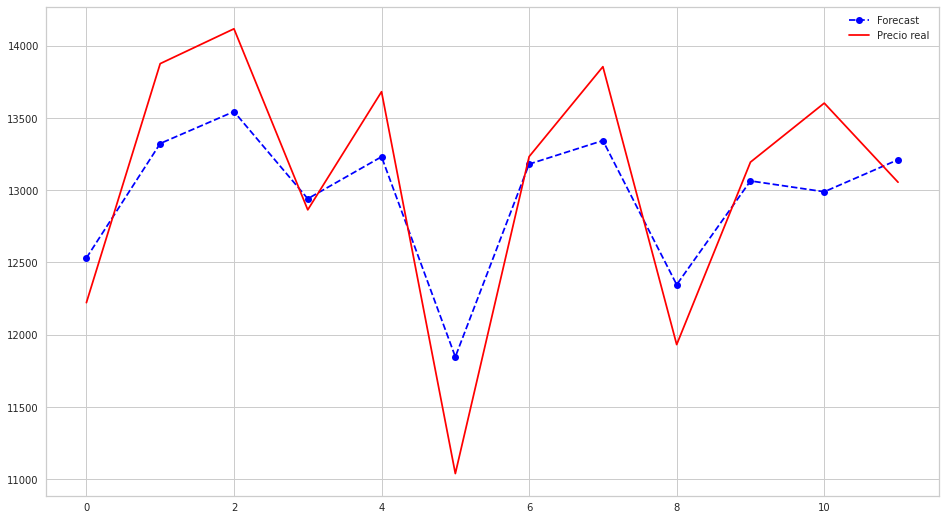

In [52]:
compare_forecast(final_predictions, final)

In [65]:
train_ml

,CO2_Emission_Ratio,Used_Ratio,Avg_CO2,Diesel_Co2,Bensin_Co2,Year,Diesel_Ratio,Diesel_Share,Quantity_YoY
0,-0.060569,-1.349953,0.993550,1.003214,1.249128,-1.565561,1.140795,1.042780,2.712717
1,0.891925,0.412076,1.170344,1.264263,1.484098,-1.565561,0.826371,0.793116,1.153347
2,0.454644,-0.010366,1.302939,1.520340,1.601583,-1.565561,0.653380,0.653948,0.590537
3,1.407079,0.946492,1.347138,1.520340,1.836553,-1.565561,0.558843,0.577324,0.062517
4,0.263911,-0.130337,1.347138,1.604626,1.719068,-1.565561,0.667074,0.668124,0.673022
...,...,...,...,...,...,...,...,...,...
104,-1.013068,0.310416,-1.304766,-0.981548,-0.865602,1.189826,-1.343358,-1.302173,0.248811
105,-1.146406,-0.233653,-1.348964,-0.981548,-0.924345,1.189826,-1.315060,-1.268640,-0.088987
106,-1.060099,-0.563101,-1.348964,-0.981548,-0.748117,1.189826,-1.315060,-1.268640,0.404804
107,-1.037001,-1.659183,-1.127972,-0.880086,-0.983087,1.189826,-1.189450,-1.121708,0.020432


## Shift and predict

In [110]:
target_shift = target.shift(-3).dropna().reset_index()

In [111]:
target_test

109    12222.0
110    13875.0
111    14116.0
112    12864.0
113    13681.0
114    11040.0
115    13232.0
116    13854.0
117    11932.0
118    13194.0
119    13602.0
120    13055.0
Name: Quantity, dtype: float64

In [112]:
target_shift_train = target_shift[0:109].Quantity
target_shift_train

0       8854.0
1      12007.0
2      11083.0
3      12062.0
4      10786.0
        ...   
104    13078.0
105    10991.0
106    12222.0
107    13875.0
108    14116.0
Name: Quantity, Length: 109, dtype: float64

In [113]:
target_shift

,index,Quantity
0,0,8854.0
1,1,12007.0
2,2,11083.0
3,3,12062.0
4,4,10786.0
...,...,...
113,113,13854.0
114,114,11932.0
115,115,13194.0
116,116,13602.0


In [115]:
for name, model in models.items():
    model.fit(train_ml, np.log(target_shift_train))
    print(name + " trained.")

huber trained.
lr trained.
br trained.
et trained.
ridge trained.
lar trained.
gbr trained.
rf trained.
xgboost trained.


In [116]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_ml, np.log(target_shift_train), scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

In [117]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
huber
1.132815625884223
0.07363766123523832
----------
lr
1.1365920435439818
0.06986371393806226
----------
br
1.1171547445298218
0.05573957483958871
----------
et
1.1108405792135299
0.056404060329063414
----------
ridge
1.119106919124665
0.062488059625338724
----------
lar
1.182965775207864
0.10926459350815457
----------
gbr
1.1191262837041287
0.05946141844528847
----------
rf
1.1196693861321643
0.06461040998734563
----------
xgboost
1.146990607686892
0.08999170157913844


In [118]:
final_predictions = (
    0.4 * np.exp(models['huber'].predict(test_ml)) +
    0.2 * np.exp(models['br'].predict(test_ml)) +
    0.2 * np.exp(models['lr'].predict(test_ml)) +
    0.1 * np.exp(models['ridge'].predict(test_ml)) +
    0.1 * np.exp(models['et'].predict(test_ml))
)

In [119]:
final_predictions

array([13160.95924037, 12902.15466359, 13455.7336013 , 13242.68539385,
       12842.69117916, 12319.58447154, 13001.8940437 , 13164.75052958,
       12484.16705632, 12945.38207278, 12881.41662263, 14131.33245644])

In [ ]:
data = pd.apiDataFrame()
data['Ml'] = final_predictions
data['Sarimax'] = sarimax

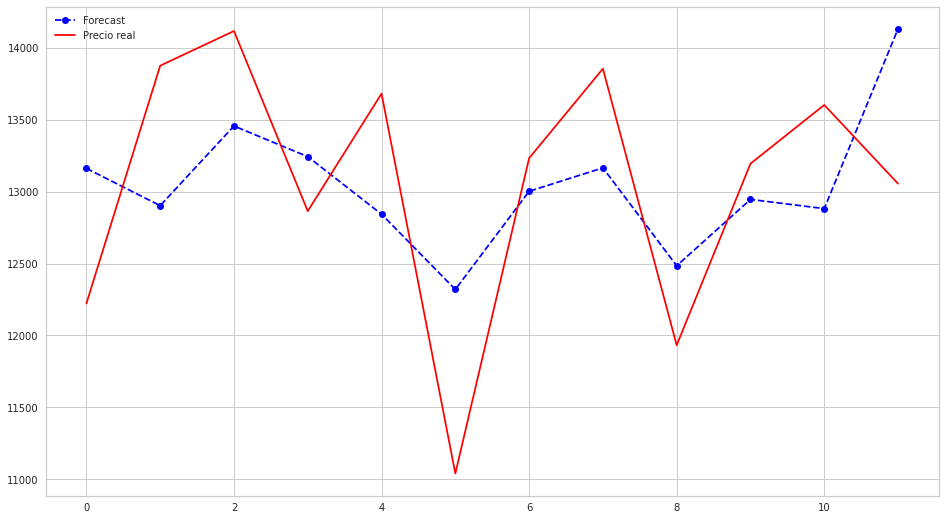

In [120]:
compare_forecast(final_predictions,final)

In [93]:


# Fit the model to the shifted data
huber_model = HuberRegressor()
huber_model.fit(train_ml, target_shift_train)

# Make predictions using the shifted data
predictions = huber_model.predict(test_ml)


In [95]:
(predictions)

array([13142.52673522, 13232.36574589, 13672.06212731, 13566.77860977,
       13240.98941694, 12857.14026226, 13443.9807354 , 14343.17395416,
       13888.97554557, 14063.60776656, 13037.41395943, 15259.53287504])

# --------------------------------------------

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Instantiate a linear regression model
lr = LinearRegression()

# Use cross_val_score to perform cross validation
scores = cross_val_score(lr, train_ml, np.log(target[:-12]), cv=5)

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross validation score: {:.2f}".format(scores.mean()))
print("Standard deviation of cross validation scores: {:.2f}".format(scores.std()))


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_ml,target[:-12] )
linear = model.predict(test_ml)
print("Predicted prices:", linear)
print("Actual prices:", target[-12:])

In [34]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
LGMB = LGBMRegressor()
LGMB.fit(train_ml,target[:-12])
GBR = GradientBoostingRegressor()
GBR.fit(train_ml,target[:-12])
GBR_predict = GBR.predict(test_ml)
LGMB_predict = LGMB.predict(test_ml)
xgb = XGBRegressor()
xgb.fit(train_ml,log_target[:-12])
xgb_predict = xgb.predict(test_ml)
print(LGMB_predict)
print(GBR_predict)
print(xgb_predict)

[12920.40938173 12351.9412093  12936.61548411 12679.63356725
 12277.44473927 10332.53525968 12605.13709722 12962.97945225
 11577.24166454 12663.42746487 12706.29270036 13066.95889741]
[11367.8214365  12798.60924226 12673.8765008  11806.49756489
 12627.90105485 11005.71329362 12557.44570902 12710.82263103
 11375.3811384  12705.52315115 12368.79850029 12639.56465374]
[9.319769 9.48098  9.396428 9.349334 9.486939 9.345083 9.521442 9.404542
 9.313674 9.395614 9.514197 9.400754]


# -----------------------
